### AIDI 1002 Assignment 3
### Author: Ahmad Sayeb - 200534271

In [167]:
# ---------------- Libraries-----------------
import pandas as pd
import numpy as np
# ---------------- Plotting------------------
import matplotlib.pyplot as plt
import seaborn as sns
# ---------------- Sklearn libraries---------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve,roc_auc_score
from imblearn.over_sampling import SMOTE
# ---------------- Keras---------------------
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
# ----------------Tensor-flow support--------
import tensorflow_addons as tfa
# -----------------Warnings------------------
#removing cuda warnings for gpu
import warnings
warnings.filterwarnings('ignore')

### All the Necessary Functions

In [246]:
def load_csv(path: str) -> 'dataframe':
    '''
    Loads csv file into dataframe
    path: path to the file
    '''
    df = pd.read_csv(path)
    return df


def num_col_nan(df: 'dataframe'):
    '''
    replaces nan value in numerical columns with mode
    df: dataframe
    '''
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    col_num = df.select_dtypes(include=numerics)
    
    for col in col_num:
        df[col].replace([np.nan], df[col].mode()[0], inplace=True)

        
def cat_col_nan(df: 'dataframe'):
    '''
    replace nan value in categorical column with None string
    df: dataframe
    '''
    
    categorical = ['object']
    cat_columns = df.select_dtypes(include=categorical)
    
    for col in cat_columns:
        df[col].replace([np.nan], 'None', inplace=True)


def encoder(df: 'dataframe', train=True, only_label=False) -> 'dataframe':
    '''
    label encoding categorical data that are indep variable
    and one hot encode target variables
    df: dataframe
    '''
    label = LabelEncoder()
    categorical = ['object']
    cat_col = df.select_dtypes(include=categorical)
    if train and only_label:
        target_only_label = cat_col[['Var_1']]
        cat_col.drop(columns=['Var_1'], inplace=True)
        for col in cat_col:
            df[col] = label.fit_transform(df[col])
        df.drop(columns=['Var_1'], inplace=True)
        return pd.concat([df, target_only_label], axis=1)
        
    if train  and not only_label:
        target = cat_col[['Var_1']]
        cat_col.drop(columns=['Var_1'], inplace=True)
    
    for col in cat_col:
        df[col] = label.fit_transform(df[col])
    
    if train and not only_label:
        target = pd.get_dummies(target)
        df.drop(columns=['Var_1'], inplace=True)
        return pd.concat([df, target], axis=1)
    if not train and not only_label:
        return df


def replacing_classes(row: 'object'):
    if row != 'Cat_4' and row != 'Cat_6':
        return 'Other'
    else:
        return row

def drop_cols(cols: list, df: 'dataframe'):
    '''
    drops specified columns
    col: list of columns
    df: dataframe
    '''
    print(f'dropping {cols}...')
    df.drop(columns=cols, inplace=True)
    
    
def pre_processing(df: 'dataframe', train=True, only_label=False):
    '''
    performs nan value replacement and encoding categorical values
    '''
    try:
        if train:
            print('dropping columns...')
            drop_cols(['ID', 'Segmentation','Age'], df)
        if not train:
            print('dropping ID column')
            drop_cols(['ID','Var_1','Age'], df)
        print('replacing numerical nans with mode...')
        num_col_nan(df)
        print('replacing categorical nans with None string...')
        cat_col_nan(df)
        if train:
            print('changing anything otehr than cat_6 and cat_4 to other...')
            df['Var_1'] = df['Var_1'].apply(replacing_classes)
        print('label encoding categorical data...')
        df = encoder(df, train, only_label)
        print('\033[1m' + 'SUCCESSFULLY PERFORMED PREPROCESSING' + '\033[0m')    
        return df
    
    except Exception as e:
        print('error occurred in pre-processing')
        print(e)
        return False

    
def train_validation_split(val_size: float, df: 'dataframe'):
    '''
    splits dataframe into train and validation and SHUFFLES
    test_size: size of the validation
    df: dataframe
    '''
    # Shuffle is set to true
    # Stratify is set to true
    df_dep = df[['Var_1_Cat_4','Var_1_Cat_6', 'Var_1_Other']]
    df_indep = df.drop(columns=['Var_1_Cat_4','Var_1_Cat_6', 'Var_1_Other'])
    X_train, X_valid, y_train, y_valid = train_test_split(
                                                        df_indep,
                                                        df_dep,
                                                        test_size=val_size, 
                                                        shuffle=True,
                                                        stratify=df_dep[['Var_1_Cat_4', 'Var_1_Cat_6', 'Var_1_Other']]
                                                        )
    
    return X_train, X_valid, y_train, y_valid


def min_max_scaler(df: 'dataframe'):
    '''
    normalize numerical data
    df: dataframe
    '''
    scaler = MinMaxScaler()
    col_num = ['Work_Experience', 'Family_Size']
    df[col_num] = scaler.fit_transform(df[col_num])


def fit_model(X_train: 'dataframe',
              y_train: 'dataframe',
              X_val: 'dataframe', 
              y_val: 'dataframe'
             ):
    '''
    This builds and trains the model
    X_trian: training data
    '''
    model = Sequential()
    model.add(Dense(512, input_shape=(7,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128))
    # dropout for regularization
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # metric is accuracy and f1_score
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tfa.metrics.F1Score(average='micro', num_classes=3),'accuracy'])
    print(model.summary())
    
    X_train_array = X_train.values
    y_train_array = y_train.values
    X_val_array = X_val.values
    y_val_array = y_val.values
    # callback to stop training if reverse learning happens
    # Patience is set to 200, stop wont happen before 200 epochs
    callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=200)
    history = model.fit(X_train_array,
                        y_train_array,
                        epochs=500,
                        verbose=1,
                        validation_data=(X_val_array, y_val_array),
                       callbacks=[callbacks])
    return history, model


# Link: https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve%20-%20Multiclass.ipynb
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list


# Link: https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve%20-%20Multiclass.ipynb
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    
# Link: https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve%20-%20Multiclass.ipynb
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

def apply_smote(df: 'dataframe') -> 'dataframe':
    '''
    This function applies SMOTE and return dataframe
    '''
    X = df.loc[:, df.columns != "Var_1"]
    y = df[['Var_1']]
    sm = SMOTE(sampling_strategy='auto', k_neighbors=1, random_state=100)
    X_res, y_res = sm.fit_resample(X, y)
    return pd.concat([X_res, y_res], axis=1)

### All Steps without Dealing Minority with Minority Class

Applying the preprocessing function to the train data. Applying min_max_scaler brought no change to the accuracy, f1_score or recall.Since most of the columns are categorical, normalization only apply to work experience column and it will reduce it importance significantly as the other columsn are values betwen 0 to 4 because of label encoding. This is the reason that I avoided normalization. We also train the model with this pipeline.
test_validation_split shuffles the data and uses stratify to include all types of classes in validation set.

In [247]:
def train_pipeline():
    '''
    performs all the necessary functions for the training
    dataset
    '''
    df = load_csv('archive/train.csv')
    df = pre_processing(df)
    X_train, X_valid, y_train, y_valid = train_validation_split(0.10, df)
    # Removing normalization: Because most of the columns
    # Are categorical and if we normalize the effect of
    # Numerical data will be very low
    # min_max_scaler(X_train)
    # min_max_scaler(X_valid)
    history, model = fit_model(X_train, y_train, X_valid, y_valid)  
    return history, model

In [248]:
history, model = train_pipeline()

dropping columns...
dropping ['ID', 'Segmentation', 'Age']...
replacing numerical nans with mode...
replacing categorical nans with None string...
changing anything otehr than cat_6 and cat_4 to other...
label encoding categorical data...
SUCCESSFULLY PERFORMED PREPROCESSING
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_175 (Dense)           (None, 512)               4096      
                                                                 
 dense_176 (Dense)           (None, 256)               131328    
                                                                 
 dense_177 (Dense)           (None, 128)               32896     
                                                                 
 dropout_75 (Dropout)        (None, 128)               0         
                                                                 
 dense_178 (Dense)           (None, 64)  

In [249]:
def test_pipeline(model):
    '''performs all the necessary steps for the testing
    dataset
    '''
    df_test = load_csv('archive/test.csv')
    df_test = pre_processing(df_test, train=False)
    y_pred = model.predict(df_test.values)
    y_test = load_csv('archive/test.csv')[['Var_1']]
    y_test['Var_1'] = y_test['Var_1'].apply(replacing_classes)
    y_test = pd.get_dummies(y_test)
    # putting predictions in a list
    # as the index of max probability
    pred = list()
    for i in range(len(y_pred)):
        pred.append(np.argmax(y_pred[i]))
    # putting test target variables in a list
    test = list()
    y_test_arr = y_test.values
    for i in range(len(y_test_arr)):
         test.append(np.argmax(y_test_arr[i]))
    
    def num_to_class(x):
        if x == 0:
            return "Var_1_Cat_4"
        if x == 1:
            return "Var_1_Cat_6"
        if x == 2:
            return "Var_1_Other"
        
    return (list(map(lambda x: num_to_class(x), pred)),
            list(map(lambda x: num_to_class(x), test)),
            y_pred,
            y_test,
           df_test)

In [250]:
pred, test, y_pred, y_test, X_test = test_pipeline(model)

dropping ID column
dropping ['ID', 'Var_1', 'Age']...
replacing numerical nans with mode...
replacing categorical nans with None string...
label encoding categorical data...
SUCCESSFULLY PERFORMED PREPROCESSING
83/83 [==============================] - 0s 547us/step


In [251]:
X_test

,Gender,Ever_Married,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,0,2,2,2,0.0,2,1.0
1,1,2,2,5,8.0,0,4.0
2,0,2,0,9,0.0,2,1.0
3,1,2,0,4,11.0,1,2.0
4,0,0,0,8,1.0,2,4.0
...,...,...,...,...,...,...,...
2622,1,0,0,5,9.0,2,4.0
2623,0,0,2,1,1.0,2,1.0
2624,0,0,2,3,1.0,2,2.0
2625,1,2,2,4,1.0,1,5.0


In [252]:
# Classification metrics for Test
print(f'f1_score for the test data is:', f1_score(pred, test, average='macro'))
print(f'recall for the test data is:', recall_score(pred, test, average='macro'))
print(f'precision score for the test data is:', precision_score(pred, test, average='macro'))
print(f'accuracy for the test data is: {accuracy_score(pred, test)}')

f1_score for the test data is: 0.2849736839965477
recall for the test data is: 0.5258282267330525
precision score for the test data is: 0.34608733916751366
accuracy for the test data is: 0.6417967263037686


recall: recall is the true positives over false negatives and true positives. In multi class the true positives mean all the value for the class A that was correctly identified. False negative means all the predictions that belonged to class A but incorrectly classified as B or C. the recall would be average recall of the recalls for all three classes.

precision: precision is the true positives over true positives and false positives. false positive are the values that belong to class B or C but was predicted incorrectly as A. precision would be the average of the precision for the three classes.

f1_score: it is the harmonic mean that punishes the extreme values. it means that if recall is high then recall would be punished and the harmonic mean would be more in the side of precision. It is a good metric for imbalance data. it is 2 times average precision time average recall over average recall and average precision.

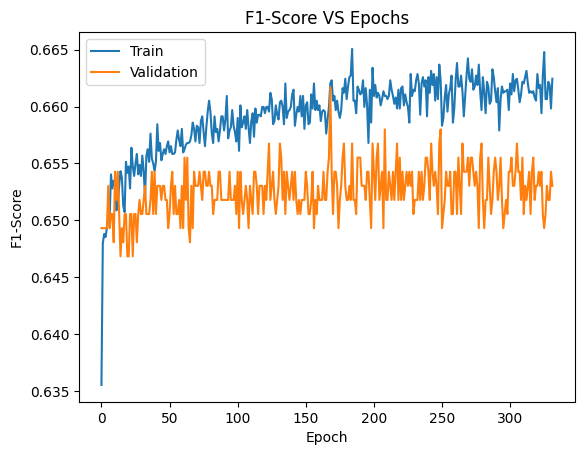

In [253]:
plt.plot(history.history['f1_score']) 
plt.plot(history.history['val_f1_score']) 
plt.title('F1-Score VS Epochs') 
plt.ylabel('F1-Score') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

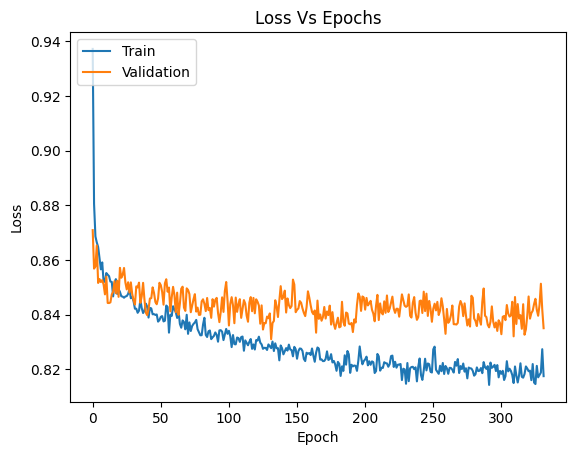

In [254]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Loss Vs Epochs') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

Model is definitely learning in training set. you can see that loss is decreasing and f1_score is increasing. However Because of small number of data (although it was shuffled and stratified) model doesn't reach its best form. The early stopage was applied and the model stopped after 332 epoch of 500 total epochs.

In [255]:
# Reference: https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a
def plot_roc_auc(test, y_pred):
    '''This plots the roc auc'''
    classes_combinations = []
    class_list = list(set(test))
    for i in range(len(class_list)):
        for j in range(i+1, len(class_list)):
            classes_combinations.append([class_list[i], class_list[j]])
            classes_combinations.append([class_list[j], class_list[i]])
    print(classes_combinations)
    plt.figure(figsize = (20, 7))
    bins = [i/20 for i in range(20)] + [1]
    roc_auc_ovo = {}
    for i in range(len(classes_combinations)):
        # Gets the class
        comb = classes_combinations[i]
        c1 = comb[0]
        c2 = comb[1]
        c1_index = class_list.index(c1)
        title = c1 + " vs " +c2

        # Prepares an auxiliar dataframe to help with the plots
        df_aux = df_test.copy()
        df_aux['class'] = test
        df_aux['prob'] = y_pred[:, c1_index]

        # Slices only the subset with both classes
        df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
        df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
        df_aux = df_aux.reset_index(drop = True)

        # Plots the probability distribution for the class and the rest
        ax = plt.subplot(2, 6, i+1)
        sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
        ax.set_title(title)
        ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
        ax.set_xlabel(f"P(x = {c1})")

        # Calculates the ROC Coordinates and plots the ROC Curves
        ax_bottom = plt.subplot(2, 6, i+7)
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
        plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
        ax_bottom.set_title("ROC Curve OvO")

        # Calculates the ROC AUC OvO
        roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
    plt.tight_layout()

[['Var_1_Cat_6', 'Var_1_Cat_4'], ['Var_1_Cat_4', 'Var_1_Cat_6'], ['Var_1_Cat_6', 'Var_1_Other'], ['Var_1_Other', 'Var_1_Cat_6'], ['Var_1_Cat_4', 'Var_1_Other'], ['Var_1_Other', 'Var_1_Cat_4']]


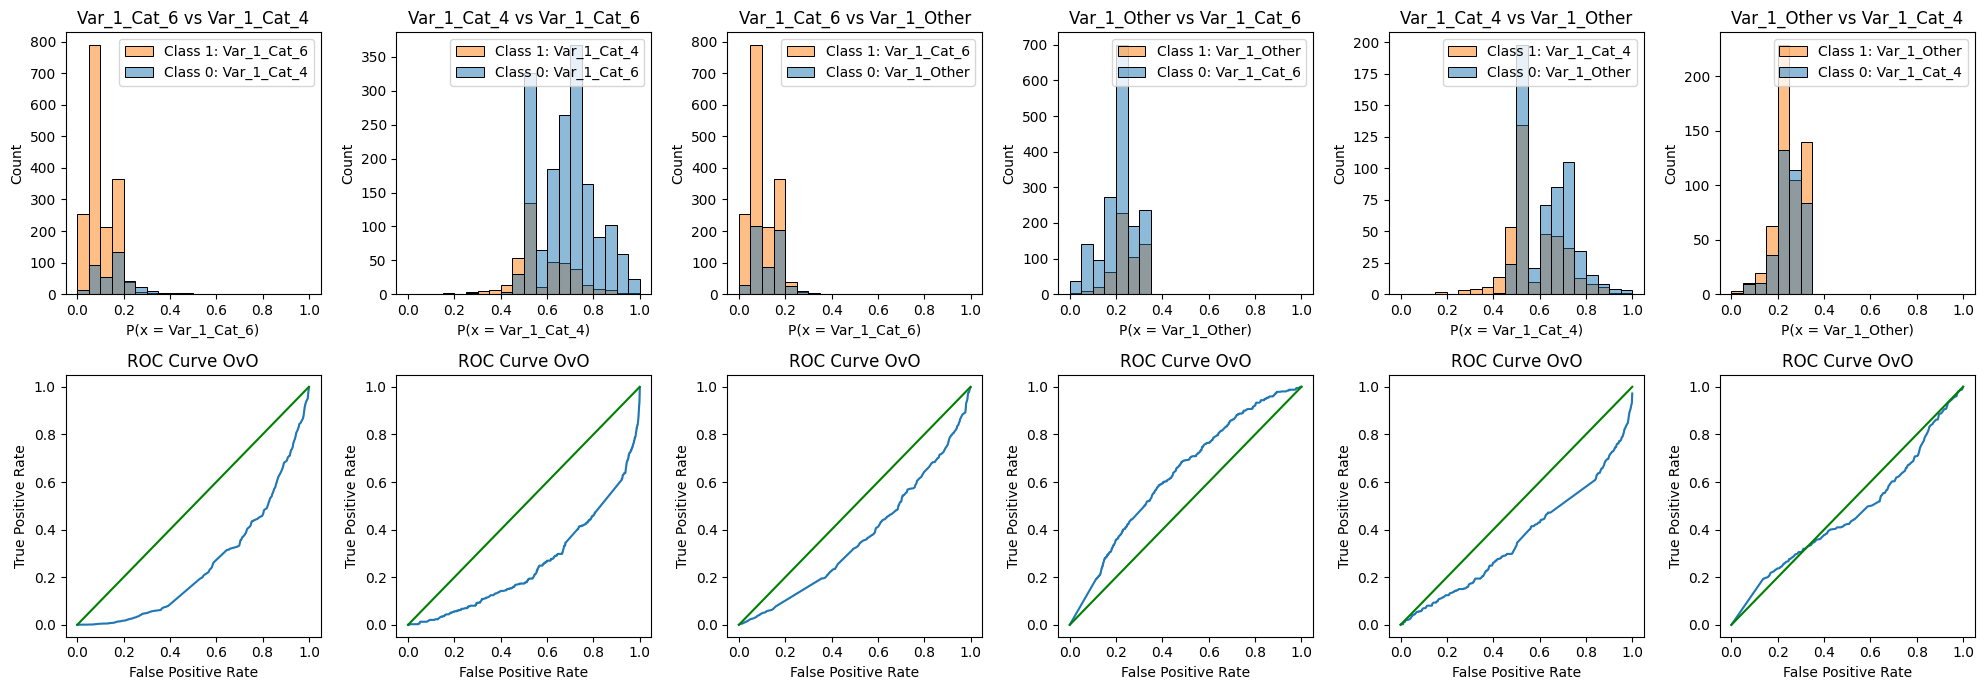

In [256]:
plot_roc_auc(test, y_pred)

ROC curves are not very promising in this mode. You can see that for most of the classes, ROC curve is below the 0.5 probability which means that model is performing worse than a coin toss. This is most probably because of a small number of data that we have. For neural network, minimum of a few million data-sets are required. However, if we look at 4th ROC graph, we might say that a False Positive of around 0.5 and True Positive of around 0.6 are good thresholds since it maximises the area under the curve.

### After Applying SMOTE for Over Sampling

In [257]:
def smote_train_pipeline():
    '''
    performs all the necessary functions for the training
    dataset
    '''
    df = load_csv('archive/train.csv')
    df = pre_processing(df, train=True, only_label=True)
    df_smote = apply_smote(df)
    print("Var_1_Cat_4 after SMOTE", len(df_smote.loc[df_smote["Var_1"] == "Cat_4"]))
    print("Var_1_Cat_6 after SMOTE", len(df_smote.loc[df_smote["Var_1"] == "Cat_6"]))
    print("Other after SMOTE", len(df_smote.loc[df_smote["Var_1"] == "Other"]))
    target = df_smote[['Var_1']]
    target = pd.get_dummies(target)
    df_smote.drop(columns=['Var_1'], inplace=True)
    df_smote = pd.concat([df_smote, target], axis=1)
    X_train, X_valid, y_train, y_valid = train_validation_split(0.10, df_smote)
    # Removing normalization: Because most of the columns
    # Are categorical and if we normalize the effect of
    # Numerical data will be very low
    # min_max_scaler(X_train)
    # min_max_scaler(X_valid)
    history_smote, model_smote = fit_model(X_train, y_train, X_valid, y_valid)  
    return history, model_smote

We applied SMOTE to increase the number minority classes. As you can see below all three classes have the same number of data points.

In [258]:
history_smote, model_smote = smote_train_pipeline()

dropping columns...
dropping ['ID', 'Segmentation', 'Age']...
replacing numerical nans with mode...
replacing categorical nans with None string...
changing anything otehr than cat_6 and cat_4 to other...
label encoding categorical data...
SUCCESSFULLY PERFORMED PREPROCESSING
Var_1_Cat_4 after SMOTE 5238
Var_1_Cat_6 after SMOTE 5238
Other after SMOTE 5238
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_182 (Dense)           (None, 512)               4096      
                                                                 
 dense_183 (Dense)           (None, 256)               131328    
                                                                 
 dense_184 (Dense)           (None, 128)               32896     
                                                                 
 dropout_78 (Dropout)        (None, 128)               0         
                          

In [259]:
pred_smote, test_smote, y_pred_smote, y_test_smote, X_test_smote = test_pipeline(model_smote)

dropping ID column
dropping ['ID', 'Var_1', 'Age']...
replacing numerical nans with mode...
replacing categorical nans with None string...
label encoding categorical data...
SUCCESSFULLY PERFORMED PREPROCESSING
83/83 [==============================] - 0s 477us/step


In [272]:
# Classification metrics for Test
print(f'f1_score for the test data is:', f1_score(pred_smote, test_smote, average='macro'))
print(f'recall for the test data is:', recall_score(pred_smote, test_smote, average='macro'))
print(f'precision for the test data is:', precision_score(pred_smote, test_smote, average='macro'))
print(f'accuracy for the test data is: {accuracy_score(pred_smote, test_smote)}')

f1_score for the test data is: 0.42865639531183425
recall for the test data is: 0.4319648903554185
precision for the test data is: 0.45932621682535535
accuracy for the test data is: 0.49105443471640653


f1_score, and precision increased compare to previous data which means that number of true positive incrased and number of false positives decreased. The model is no longer identifying what belongs to class B and C as Class A.This makes sense as we increased number of minority classes and made a balanced dataset. Now that recall and precision is closer to each other and greater than 0.4 the Harmonic mean (f1_score) has also increased significantly from 0.28 to 0.42. If we had larger dataset to better trian our model, we would have good metrics.

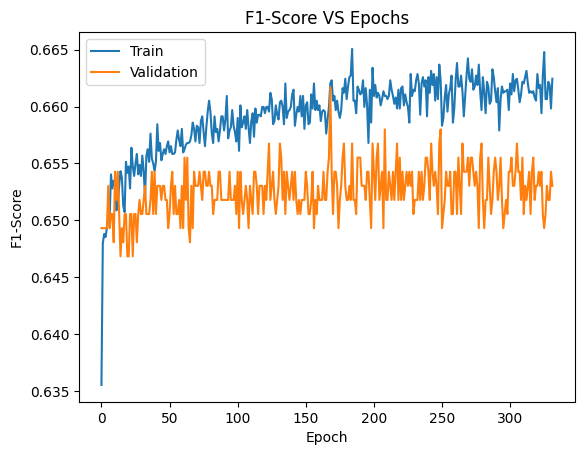

In [261]:
plt.plot(history_smote.history['f1_score']) 
plt.plot(history_smote.history['val_f1_score']) 
plt.title('F1-Score VS Epochs') 
plt.ylabel('F1-Score') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

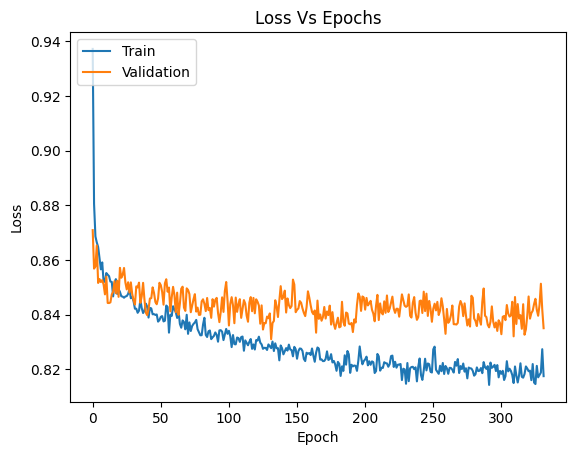

In [262]:
plt.plot(history_smote.history['loss']) 
plt.plot(history_smote.history['val_loss']) 
plt.title('Loss Vs Epochs') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

Similiar to previous situation, model is learning and loss is decreasing while f1_score is increasing. We would have achieved a better result if we had more data and trained with a more complicated (more layers and neurons) model. 

[['Var_1_Cat_6', 'Var_1_Cat_4'], ['Var_1_Cat_4', 'Var_1_Cat_6'], ['Var_1_Cat_6', 'Var_1_Other'], ['Var_1_Other', 'Var_1_Cat_6'], ['Var_1_Cat_4', 'Var_1_Other'], ['Var_1_Other', 'Var_1_Cat_4']]


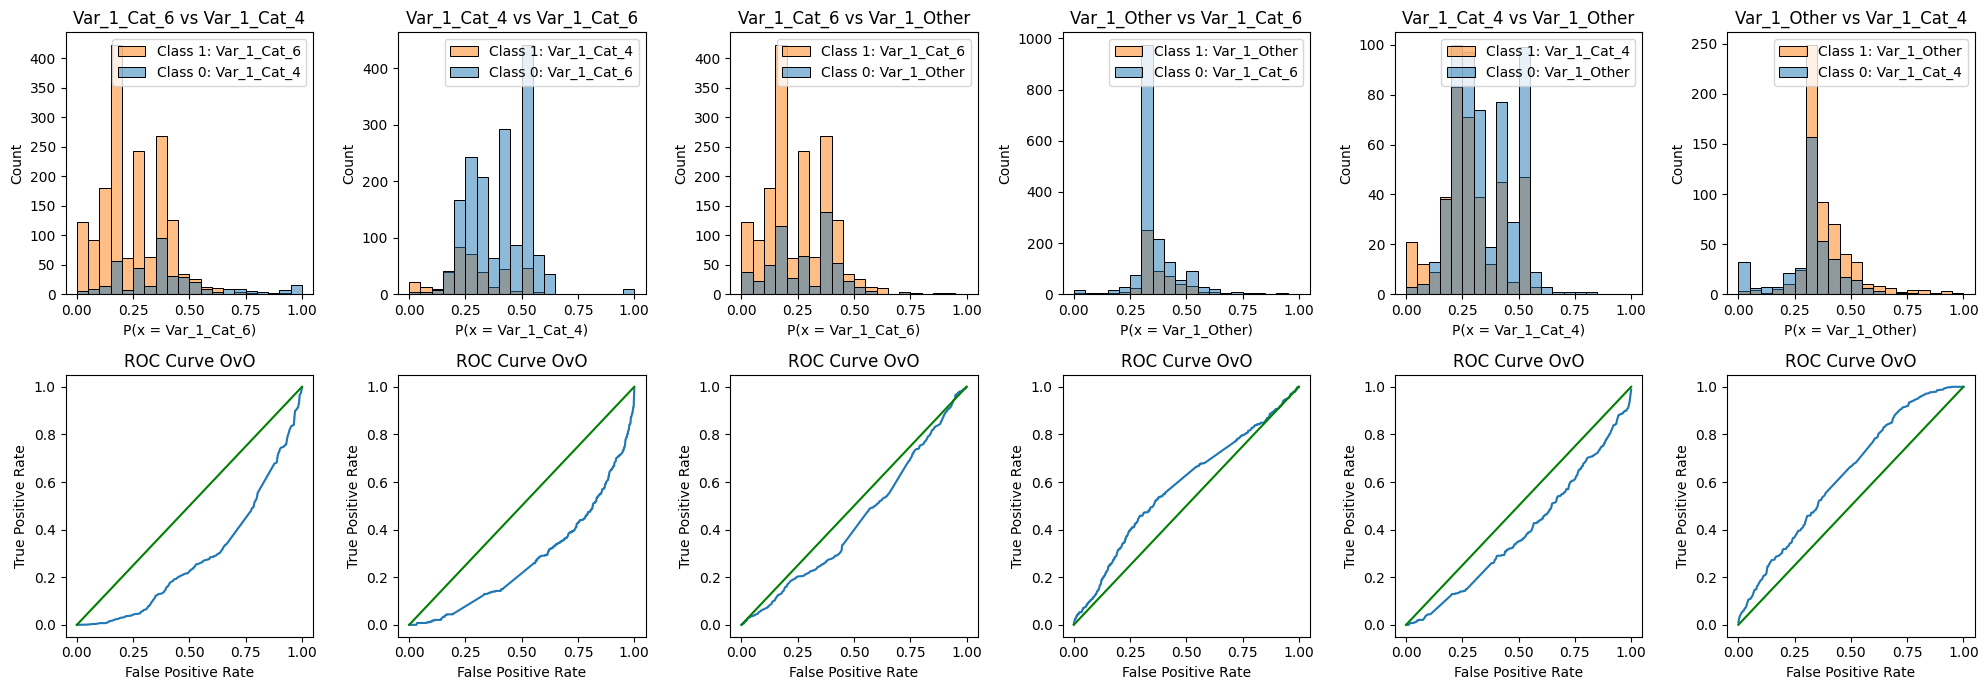

In [263]:
plot_roc_auc(test_smote, y_pred_smote)

While overall our model is not a good model but after SMOTE you can see that because we increased number of Cat_4 and Other classes we are getting slightly better ROC curve (more area under the curve) for Other vs Cat_6, Cat_6 vs Other, Other vs Cat_4 and Cat_4 vs Other.